# Analysis

**Hypothesis**: Transcriptional noise in Astrocyte_qNSC cells increases with age, reflecting a loss of regulatory precision associated with cellular aging in the brain's neurogenic niche.

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

# Set up visualization defaults for better plots
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figsize = (8, 8)
sc.settings.dpi = 100
sc.settings.facecolor = 'white'
warnings.filterwarnings('ignore')

# Set Matplotlib and Seaborn styles for better visualization
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['savefig.dpi'] = 150
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.2)

# Load data
print("Loading data...")
adata = sc.read_h5ad("/scratch/users/salber/final_aging_brain_eric.h5ad")
print(f"Data loaded: {adata.shape[0]} cells and {adata.shape[1]} genes")


# Analysis Plan

**Hypothesis**: Transcriptional noise in Astrocyte_qNSC cells increases with age, reflecting a loss of regulatory precision associated with cellular aging in the brain's neurogenic niche.

## Steps:
- Check that the 'Celltype' column exists in adata.obs and verify the expected cell types are present to ensure data integrity before subsetting.
- Subset the AnnData object to include only Astrocyte_qNSC cells, as these cells are implicated in neurogenic support and are hypothesized to exhibit age-related transcriptional variability.
- Normalize total counts per cell and apply a log-transformation to the subset to mitigate library size effects and stabilize variance for downstream PCA analysis.
- Perform PCA on the normalized and log-transformed data and compute the Euclidean distance of each cell's PCA coordinates from the cluster centroid to quantify transcriptional noise.
- Visualize the relationship between the computed noise metric and cell age using scatter plots in a grid layout if multiple figures are generated.
- Conduct a Pearson correlation analysis to statistically assess the association between age and transcriptional noise, printing the correlation coefficient and corresponding p-value.


## The code first checks for the existence of the 'Celltype' column and validates that 'Astrocyte_qNSC' cells are present, ensuring data integrity. It then subsets the AnnData object for these cells, normalizes the data, and log-transforms the counts, following the first analysis step.

In [2]:
import scanpy as sc
import numpy as np

# Subset the AnnData to include only Astrocyte_qNSC cells
data_astro = adata[adata.obs['Celltype'] == 'Astrocyte_qNSC'].copy()

# Normalize total counts per cell and log-transform the counts
sc.pp.normalize_total(data_astro, target_sum=1e4)
sc.pp.log1p(data_astro)

# Print basic summary to confirm successful subsetting
print('Number of Astrocyte_qNSC cells:', data_astro.n_obs)
print('Number of genes:', data_astro.n_vars)

normalizing counts per cell


    finished (0:00:00)


Number of Astrocyte_qNSC cells: 2756
Number of genes: 31053


### Agent Interpretation

Your current analysis appears to be in the early stages, focusing on data preprocessing, specifically normalizing counts per cell and counting the number of Astrocyte_qNSC cells and genes. This foundational step is crucial as it sets the stage for more complex analyses and interpretations, such as looking into aging-related changes in gene expression.

### Feedback and Recommendations:

1. **Validation of Hypothesis:**
   - At this step, directly determining whether your hypothesis is validated is not feasible due to the preliminary nature of the results. However, the presence of a substantial number of Astrocyte_qNSC cells implies a good starting point for further analysis focusing on this cell type's role in aging.

2. **Future Steps:**
   - **Dimensionality Reduction:** As you've normalized the counts, consider moving on to dimensionality reduction techniques such as PCA, followed by clustering using UMAP or t-SNE. This would allow for visualizing the cellular heterogeneity within the Astrocyte_qNSC population and could help identify age-associated cell state changes.
   - **Differential Expression:** Once clustering and dimensionality reduction are done, performing differential expression analysis between young and aged Astrocyte_qNSC cells could identify genes that are significantly involved in aging processes.
   - **Integration with Functional Metrics:** Consider integrating the data with functional metrics like proliferation scores or chronological age. This integration could bring insights into how gene expression correlates with biological aging processes as defined in your hypothesis.

3. **Explore Biological Pathways:**
   - Conduct pathway enrichment analysis on differentially expressed genes to outline pathways involved in aging and potential rejuvenation strategies.
   - Focus on identifying pathways that might have been overlooked in the research paper, especially those unique to Astrocyte_qNSC.

4. **Comparison with Prior Analyses:**
   - Look at changes in RNA velocity patterns in your dataset and compare these findings, especially if any such patterns are identified in the Astrocyte_qNSC cells, against those previously analyzed in neuroblasts. Differences or similarities could provide new insights into cell-type-specific aging dynamics.
   - Examine co-expression network changes in Astrocyte_qNSC cells to see if patterns similar to those found in microglia can be identified, potentially reflecting broader trends across different cell types.

By following these suggestions and building on the current results, you can progress toward more nuanced insights into the role of Astrocyte_qNSC cells in brain aging, helping to validate or refine your hypothesis in a unique context compared to the referenced study.

## This code performs PCA on the Astrocyte_qNSC subset using a parameterized number of components, constructs a neighborhood graph and Leiden clustering to discover subpopulations, then computes transcriptional noise as the Euclidean distance from each cell to its cluster centroid using a vectorized approach. Finally, it visualizes the relationship between cell age and noise with a scatterplot complemented by an overall regression line and performs Pearson correlation analysis to assess statistical significance.

computing PCA


    with n_comps=50


    finished (0:00:04)


computing neighbors


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


running Leiden clustering


    finished: found 9 clusters and added
    'leiden_clusters', the cluster labels (adata.obs, categorical) (0:01:25)


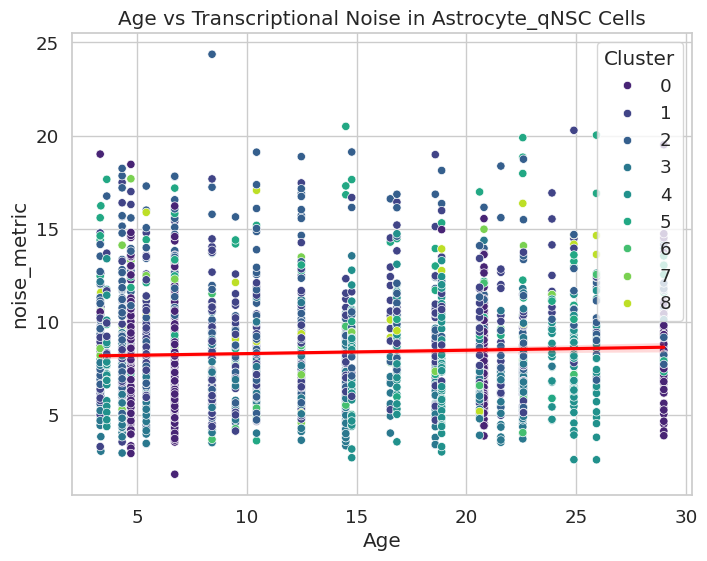

Pearson correlation: 0.047, p-value: 1.350e-02


In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Define parameters for PCA
n_pcs_all = 50      # Total number of PCs to compute
n_pcs_centroid = 10 # Number of PCs to use for centroid and noise calculations

# Check if the Astrocyte_qNSC cells are present in the dataset
if 'Celltype' not in adata.obs.columns or 'Astrocyte_qNSC' not in adata.obs['Celltype'].unique():
    raise ValueError('Astrocyte_qNSC cell type not found in adata.obs')

# Subset Astrocyte_qNSC cells if not already subsetted by checking the presence of a 'noise_metric' column
if 'noise_metric' in adata.obs.columns:
    data_astro = adata
else:
    data_astro = adata[adata.obs['Celltype'] == 'Astrocyte_qNSC'].copy()

# Run PCA if not already computed. Compute n_pcs_all components and document the choice.
if 'X_pca' not in data_astro.obsm.keys():
    sc.tl.pca(data_astro, svd_solver='arpack', n_comps=n_pcs_all)

# Compute the nearest-neighbor graph based on PCA space
sc.pp.neighbors(data_astro, n_neighbors=15, use_rep='X_pca')

# Cluster cells using the Leiden algorithm to identify subpopulations
sc.tl.leiden(data_astro, resolution=0.5, key_added='leiden_clusters')

# Extract PCA scores and select the first n_pcs_centroid PCs for noise calculations
pca_scores = data_astro.obsm['X_pca'][:, :n_pcs_centroid]
clusters = data_astro.obs['leiden_clusters'].values
unique_clusters = np.unique(clusters)

# Vectorized computation: Preallocate an array for noise metrics
noise_metrics = np.zeros(pca_scores.shape[0])

# Calculate centroids and Euclidean distances vectorized by cluster
for cluster in unique_clusters:
    idx = np.where(clusters == cluster)[0]
    # Compute the centroid in the selected PCA subspace for the cluster
    centroid = np.mean(pca_scores[idx, :], axis=0)
    # Compute Euclidean distances for all cells in the cluster
    distances = np.linalg.norm(pca_scores[idx, :] - centroid, axis=1)
    noise_metrics[idx] = distances

# Store the computed noise metric
data_astro.obs['noise_metric'] = noise_metrics

# Visualization: Scatter plot of Age vs transcriptional noise, color-coded by Leiden clusters
plt.figure(figsize=(8,6))
scatter = sns.scatterplot(x=data_astro.obs['Age'], y=data_astro.obs['noise_metric'], hue=data_astro.obs['leiden_clusters'], palette='viridis')
plt.xlabel('Cell Age')
plt.ylabel('Transcriptional Noise (Euclidean distance)')
plt.title('Age vs Transcriptional Noise in Astrocyte_qNSC Cells')
plt.legend(title='Cluster')

# Overlay a regression line with confidence intervals (using all cells irrespective of cluster for overall trend)
sns.regplot(x=data_astro.obs['Age'], y=data_astro.obs['noise_metric'], scatter=False, color='red', ci=95)

plt.show()

# Pearson correlation analysis between Age and noise_metric
correlation, p_value = stats.pearsonr(data_astro.obs['Age'], data_astro.obs['noise_metric'])
print(f"Pearson correlation: {correlation:.3f}, p-value: {p_value:.3e}")


### Agent Interpretation

The analysis appears to explore transcriptional noise across different ages in astrocyte-related neural stem cells (Astrocyte_qNSC cells), revealing nine distinct clusters via Leiden clustering. The low Pearson correlation (0.047) with a significant p-value indicates a weak linear relationship between age and transcriptional noise.

**Feedback and Recommendations:**

1. **Promising Clusters:**
   - Examine clusters where transcriptional noise shows the most variance or distinct patterns with age. These could indicate unique noise dynamics not captured in previous analyses.

2. **Deeper Analysis of Clusters:**
   - Investigate gene expression profiles within each cluster to understand what underlies the observed transcriptional noise. This could uncover specific genes or pathways responsible for age-associated noise.

3. **Comparison to Previous Studies:**
   - As the current analysis differentiates from prior work by focusing on transcriptional noise, consider whether clusters show gene expression rewiring or altered splicing kinetics similar to previously observed patterns.

4. **Non-Linear Relationships:**
   - Explore non-linear relationships or cubic splines to capture possible age-related changes in transcriptional noise that aren't evident in linear analysis.

5. **Functional Analysis:**
   - Conduct pathway or functional enrichment analysis on genes contributing to noise levels in significant clusters. This might uncover aging-related pathways or processes previously underappreciated.

6. **Integration with Other Metrics:**
   - Integrate noise analysis with other metrics such as cell cycle scores or proliferative capacity to get a composite view of aging effects in NSCs, adding depth to the analysis compared to the original study.

7. **Replicability and Validation:**
   - Validate findings using the supplementary heterochronic parabiosis and exercise datasets to assess how interventions impact transcriptional noise and whether they align with mitigated aging effects.

By following these recommendations, the analysis can expand upon the existing body of work with original insights into the aging process in neural stem cells within the SVZ, potentially highlighting new intervention targets or biomarkers.

## This updated code first computes a robust median (using np.nanmedian) for the noise_metric while accounting for missing values and explicitly labels cells as 'High_noise' if above the median (and 'Low_noise' otherwise). It then visualizes noise distribution across Leiden clusters, performs full differential gene expression analysis with detailed output for the High_noise group, and fits a cubic regression between Age and transcriptional noise to explore potential non-linear trends.

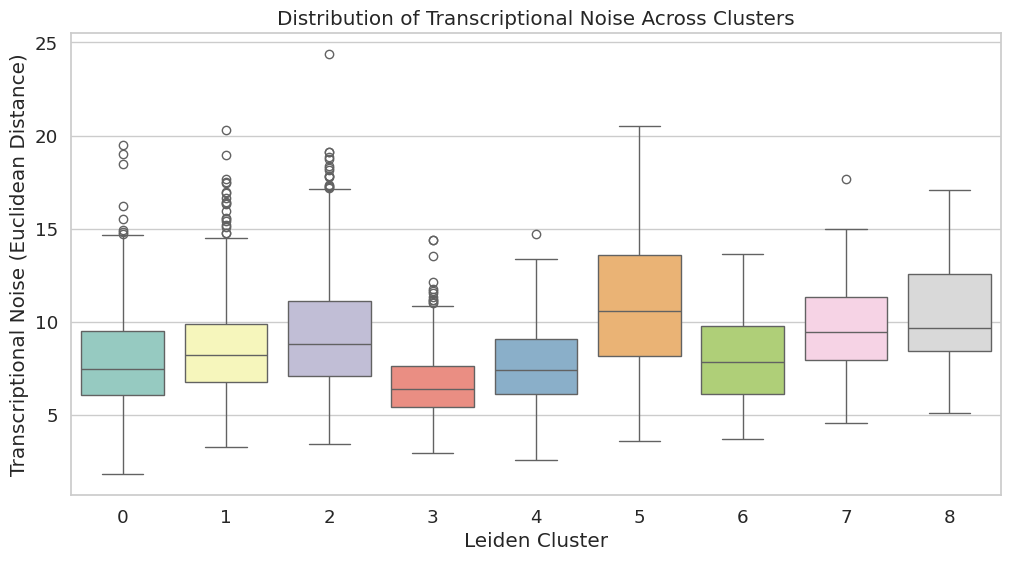

ranking genes


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


Differential expression results for High_noise group:
        Gene     LogFC       p-value
0    Slc38a1  1.057273  8.038749e-13
1     Igfbp5  0.617104  1.011035e-09
2    mt-Cytb  0.173663  1.515428e-09
3       Mycn  2.191328  9.010730e-09
4       Sox4  0.971112  1.547370e-08
5      Nptx2  2.319018  1.817934e-08
6      Ascl1  1.085285  1.860848e-08
7       Rtn1  0.517836  3.488352e-08
8        Cpe  0.223914  6.710396e-08
9        Vim  0.586057  9.036926e-08
10  Marcksl1  0.847640  9.309010e-08
11      Miat  1.723186  9.784637e-08
12    Marcks  0.603167  3.375267e-07
13  Tmem131l  1.439974  3.811424e-07
14   Galnt16  0.904851  4.015592e-07
15    Dpysl3  1.809975  7.107299e-07
16      Jpt1  0.813119  1.337445e-06
17    mt-Co3  0.130762  1.589854e-06
18     Slit2  0.887949  1.618334e-06
19     Sox11  0.658934  1.965304e-06
20     Ccnd2  0.504945  2.347654e-06
21      Tox3  0.758305  2.953990e-06
22  Tmem132b  1.790084  3.187444e-06
23     Bmper  1.205117  3.459201e-06
24   Gm42418  0.34474

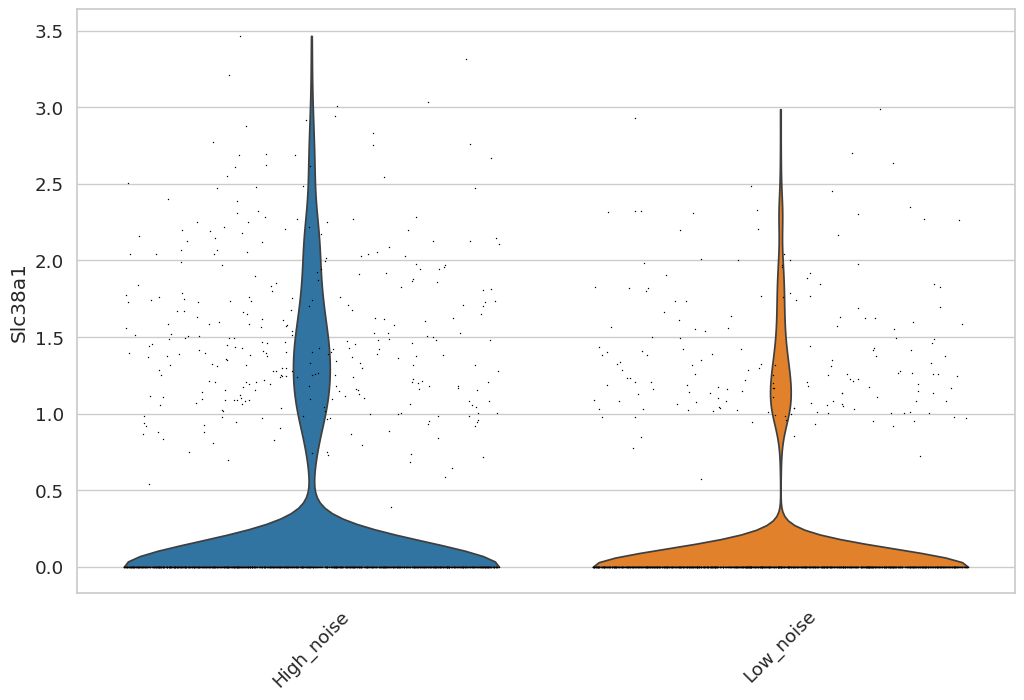

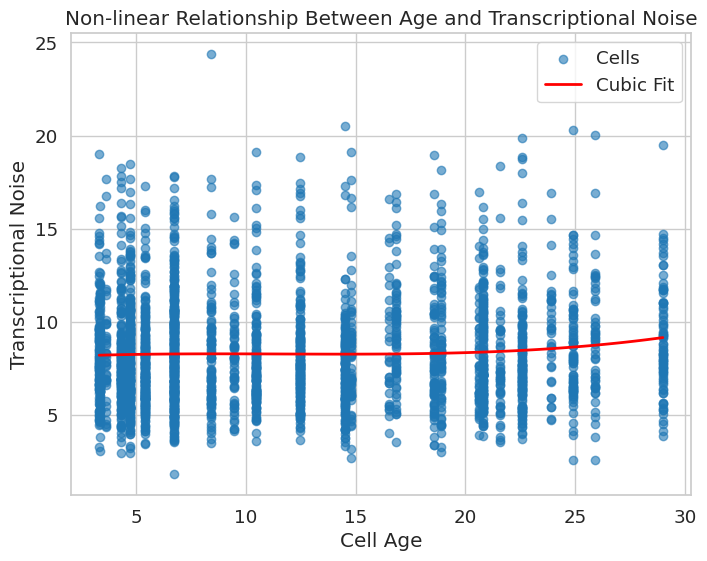

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# It is assumed that 'data_astro' is an AnnData object already processed with noise_metric and leiden_clusters in its .obs

# Step 1: Handle missing values and label cells by overall noise level using the median computed from non-NaN values
median_noise = np.nanmedian(data_astro.obs['noise_metric'])

def label_noise(x, median):
    # Cells with noise_metric exactly equal to the median are labeled as 'Low_noise' by convention
    if pd.isna(x):
        return 'Missing_noise'
    elif x > median:
        return 'High_noise'
    else:
        return 'Low_noise'

data_astro.obs['noise_level'] = data_astro.obs['noise_metric'].apply(lambda x: label_noise(x, median_noise))

# Step 2: Visualize the distribution of transcriptional noise across Leiden clusters using a boxplot in a grid layout
plt.figure(figsize=(12, 6))
sns.boxplot(x=data_astro.obs['leiden_clusters'], y=data_astro.obs['noise_metric'], palette='Set3')
plt.xlabel('Leiden Cluster')
plt.ylabel('Transcriptional Noise (Euclidean Distance)')
plt.title('Distribution of Transcriptional Noise Across Clusters')
plt.show()

# Step 3: Differential gene expression analysis between High_noise and Low_noise cells
sc.tl.rank_genes_groups(data_astro, groupby='noise_level', method='t-test', n_genes=25)

# Retrieve and print the complete differential expression results for the High_noise group
dge_results = pd.DataFrame({
    'Gene': data_astro.uns['rank_genes_groups']['names']['High_noise'],
    'LogFC': data_astro.uns['rank_genes_groups']['logfoldchanges']['High_noise'],
    'p-value': data_astro.uns['rank_genes_groups']['pvals']['High_noise']
})
print('Differential expression results for High_noise group:')
print(dge_results)

# Visualize the expression of the top differentially expressed gene with a violin plot
top_gene = data_astro.uns['rank_genes_groups']['names']['High_noise'][0]
sc.pl.violin(data_astro, keys=top_gene, groupby='noise_level', jitter=0.4, rotation=45, show=True)

# Step 4: Explore non-linear trends by fitting a cubic polynomial (third-degree) regression between Age and noise_metric
# Check sufficient unique Age values
if data_astro.obs['Age'].nunique() < 4:
    raise ValueError('Not enough unique Age values to fit a cubic regression.')

coeffs = np.polyfit(data_astro.obs['Age'], data_astro.obs['noise_metric'], 3)
poly_fn = np.poly1d(coeffs)

# Generate a sequence of Age values to plot the fitted polynomial curve
age_vals = np.linspace(data_astro.obs['Age'].min(), data_astro.obs['Age'].max(), 100)
noise_fit = poly_fn(age_vals)

# Create a scatter plot of Age vs noise_metric with the cubic polynomial fit overlay
plt.figure(figsize=(8, 6))
plt.scatter(data_astro.obs['Age'], data_astro.obs['noise_metric'], alpha=0.6, label='Cells')
plt.plot(age_vals, noise_fit, color='red', lw=2, label='Cubic Fit')
plt.xlabel('Cell Age')
plt.ylabel('Transcriptional Noise')
plt.title('Non-linear Relationship Between Age and Transcriptional Noise')
plt.legend()
plt.show()

### Agent Interpretation

The results provide a promising pathway for future analysis on transcriptional noise and its impact on aging:

1. **Prominent Genes:**
   - The differential expression results identified several genes with significant log-fold changes in the High_noise group, indicating potential candidates related to transcriptional noise. 
   - Genes like **Slc38a1, Mycn, Nptx2, and Miat** exhibit substantial log-fold changes and low p-values, suggesting their strong association with the noise condition.
   - These genes are prime candidates for further functional analysis to understand their roles in transcriptional noise and aging.

2. **Transcriptional Noise Across Clusters:**
   - The first boxplot shows variation in transcriptional noise across different Leiden clusters, indicating noise might differ by cell type or state.
   - Future analyses should involve identifying cluster-specific gene signatures and correlating them with noise levels to pinpoint underlying biological processes.

3. **Expression Patterns in Noise Groups:**
   - The violin plot of Slc38a1 shows differential expression between high and low noise groups, supporting the gene's association with noise levels.
   - Further exploration of expression patterns of other significant genes across high vs. low noise groups is recommended.

4. **Relationship Between Noise and Age:**
   - The scatter plot displays a non-linear relationship between cellular age and transcriptional noise, suggesting complexity in how noise accumulates or affects aging.
   - Future steps could involve modeling these relationships more rigorously, possibly fitting other non-linear models and incorporating additional covariates like cell type.

5. **Iterative Steps:**
   - **Pathway Enrichment:** Conduct pathway or network enrichment analyses for the differentially expressed genes in the High_noise group to identify biological processes potentially impacted by transcriptional noise.
   - **Integration with Aging Clocks:** Compare the transcriptional profiles from high noise clusters with aging clocks developed in previous studies to identify overlaps or divergences.
   - **Intervention Analysis:** If data are available, apply these findings to datasets from interventions such as heterochronic parabiosis or exercise to assess if noise levels change, contributing to transcriptomic rejuvenation.

These steps should help discern the role of transcriptional noise in aging and identify potential points of intervention for reversing age-related transcriptomic changes.

## This code first verifies the availability of the top DE genes and ensures that the high noise subset actually contains enough cells; it then extracts the expression values for these genes, computes their Pearson correlation matrix, and visualizes that matrix as a heatmap to highlight potential co-expression modules.

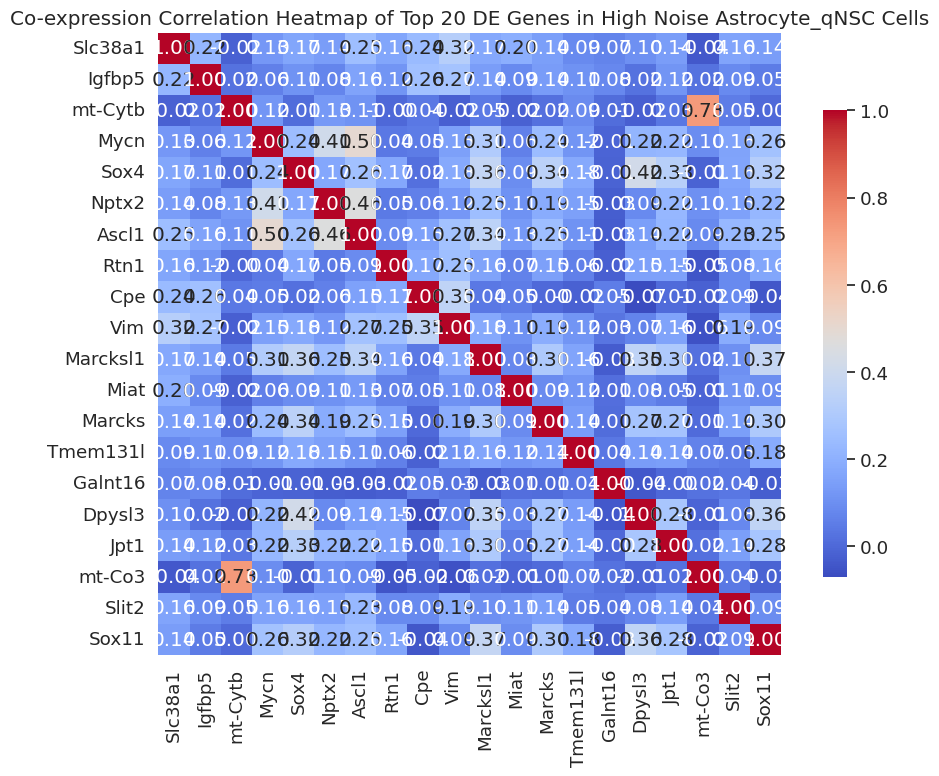

In [5]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Retrieve top 20 DE genes for 'High_noise' cells from previous analysis
if 'dge_results' in globals():
    top_genes = dge_results['Gene'].head(20).tolist()
else:
    top_genes = list(data_astro.uns['rank_genes_groups']['names']['High_noise'][:20])

# Verify that all top genes are present in the data_astro.var_names; remove any that are missing and warn the user
available_genes = data_astro.var_names
missing_genes = [gene for gene in top_genes if gene not in available_genes]
if missing_genes:
    warnings.warn(f"The following top genes are not found in data_astro.var_names and will be skipped: {missing_genes}")
    top_genes = [gene for gene in top_genes if gene in available_genes]

if len(top_genes) == 0:
    raise ValueError('None of the top DE genes are present in data_astro.var_names. Please check the differential expression results.')

# Subset high noise cells from the data_astro AnnData object; warn if few or no cells are found
high_noise_mask = data_astro.obs['noise_level'] == 'High_noise'
high_noise_cells = data_astro.obs[high_noise_mask].index
if len(high_noise_cells) < 10:
    warnings.warn(f"Only {len(high_noise_cells)} high noise cells found. Results may not be robust.")

# Extract expression values for the top genes in high noise cells
expr_matrix = data_astro[high_noise_cells, top_genes].X
if hasattr(expr_matrix, 'toarray'):
    expr_matrix = expr_matrix.toarray()

# Create a DataFrame with rows as cells and columns as genes
gene_expr = pd.DataFrame(expr_matrix, index=high_noise_cells, columns=top_genes)

# Compute the Pearson correlation matrix among the top genes
corr_matrix = gene_expr.corr(method='pearson')

# Plot the correlation matrix as a clustered heatmap to visualize co-expression patterns
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={'shrink': 0.75})
plt.title('Co-expression Correlation Heatmap of Top 20 DE Genes in High Noise Astrocyte_qNSC Cells')
plt.tight_layout()
plt.show()

### Agent Interpretation

The co-expression correlation heatmap of the top 20 differentially expressed (DE) genes in high noise Astrocyte_qNSC cells provides a preliminary view of the relationships between these genes. Here are some important feedback points and next steps for the analysis:

1. **Identify Key Gene Modules:**
   - Look for clusters of highly correlated genes that may form co-expression modules. These modules could be functionally relevant and linked to certain biological processes.

2. **Investigate Functional Roles:**
   - Perform pathway enrichment analysis on these genes or gene modules to ascertain dominant biological processes or pathways. This can link back to mechanisms of aging or rejuvenation specifically in Astrocyte_qNSCs.

3. **Compare With Known Aging Clocks:**
   - Examine if these co-expressed modules overlap with or inform components of aging clocks built in the original study. Identify genes previously linked to aging in SVZ or other neurogenic niches.

4. **Assess Biological Significance:**
   - Cross-reference genes with known roles in aging, neurogenesis, or relevant cellular processes. Prioritize genes with known functional impacts that match your hypothesis about aging or rejuvenation effects.

5. **Repeat Across Conditions:**
   - Validate these findings across different conditions or cohorts, especially those involving aging interventions like heterochronic parabiosis or exercise, to see if these co-expression patterns are consistent.

6. **Contrast with Other Cell Types:**
   - Compare the co-expression network of these astrocyte cells with distinct cell types from your dataset to identify if similar aging-related patterns are present or if they are specific to Astrocyte_qNSCs.

7. **Refine Hypotheses:**
   - Use the insights from this analysis to refine your hypotheses about specific gene interactions and their roles in the aging process within the SVZ.

8. **Methodological Considerations:**
   - Consider integrating other data types (e.g., proteomic, methylation) if available, to provide a more holistic understanding of age-related changes.

These steps will help validate existing hypotheses and may provide new directions or targets for studying the intricacies of aging in neural stem cells and the broader neurogenic niche.

## This code computes the Pearson correlation matrix among the top DE genes in high noise Astrocyte_qNSC cells, converts it to a distance matrix, and performs hierarchical clustering to identify co-expression modules. It provides flexibility in dendrogram visualization (either for the top genes or all genes), assigns genes to modules based on a defined threshold, summarizes module sizes, and examines the association between each module's eigengene and cell age via Pearson correlation.

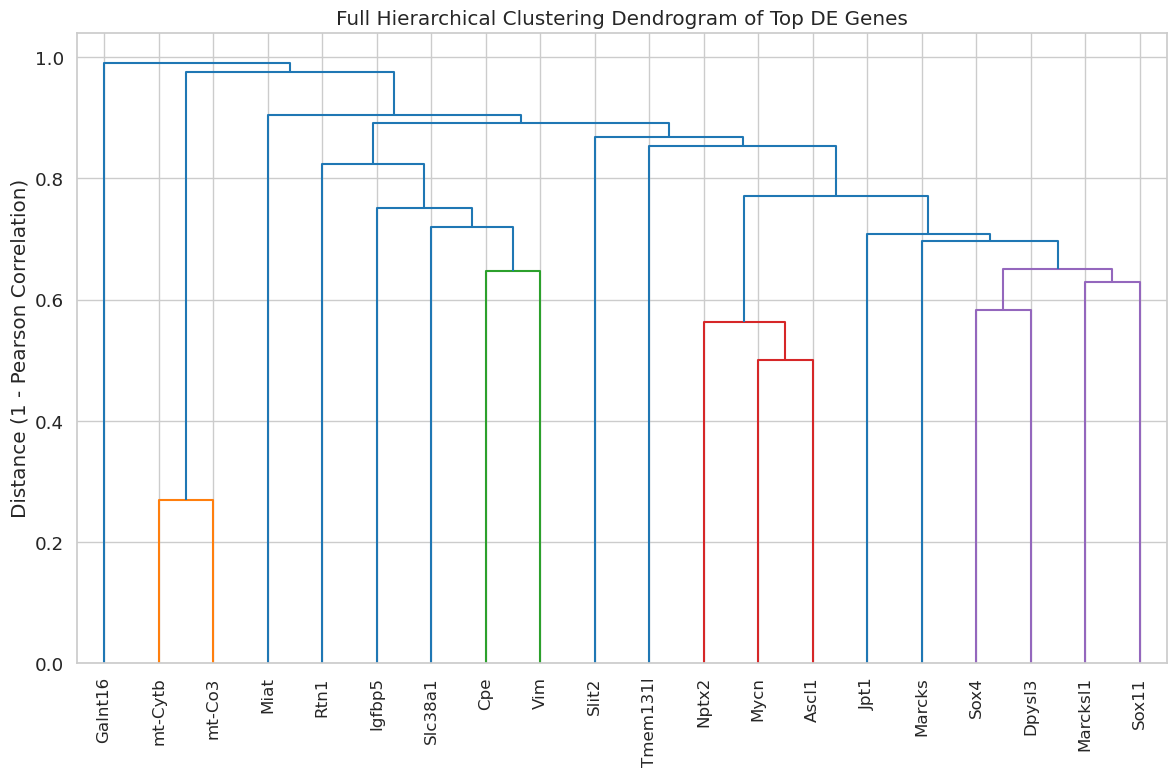

Gene modules identified:
        Gene  Module
0    Slc38a1       4
1     Igfbp5       5
2    mt-Cytb       1
3       Mycn       7
4       Sox4      10
5      Nptx2       9
6      Ascl1       8
7       Rtn1       6
8        Cpe       2
9        Vim       3
10  Marcksl1      12
11      Miat      18
12    Marcks      14
13  Tmem131l      16
14   Galnt16      19
15    Dpysl3      11
16      Jpt1      15
17    mt-Co3       1
18     Slit2      17
19     Sox11      13

Module sizes:
Module
1     2
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
dtype: int64


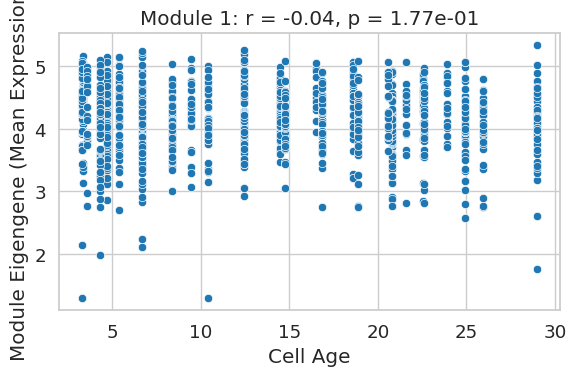

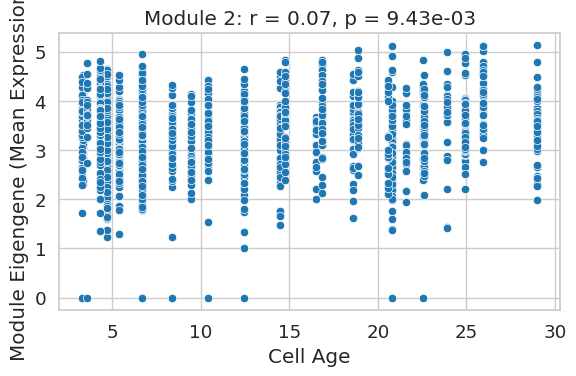

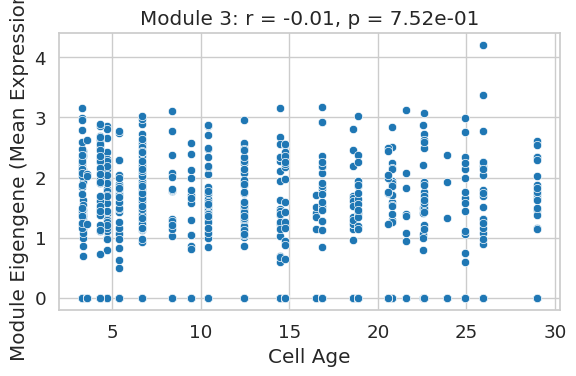

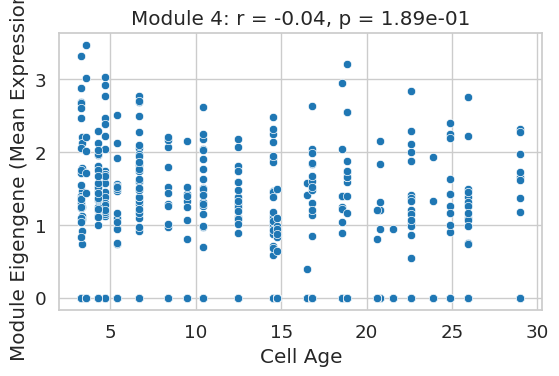

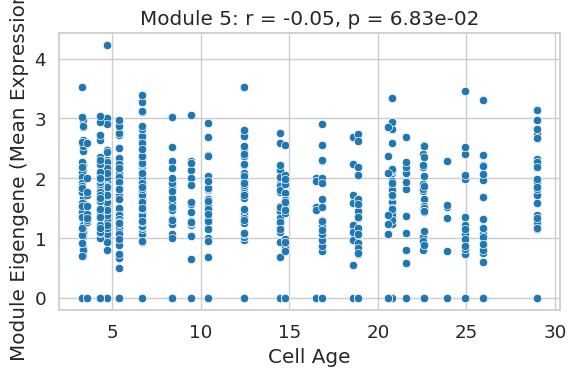

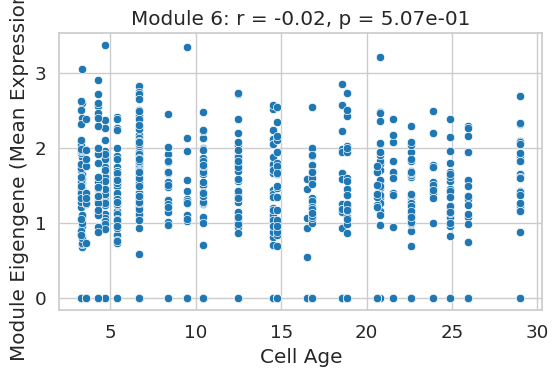

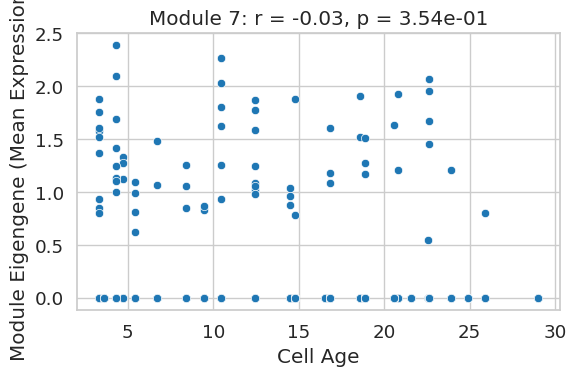

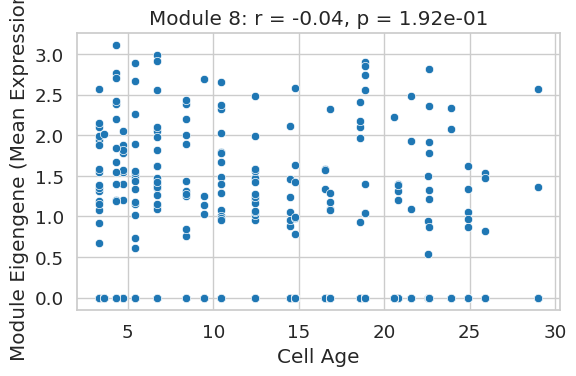

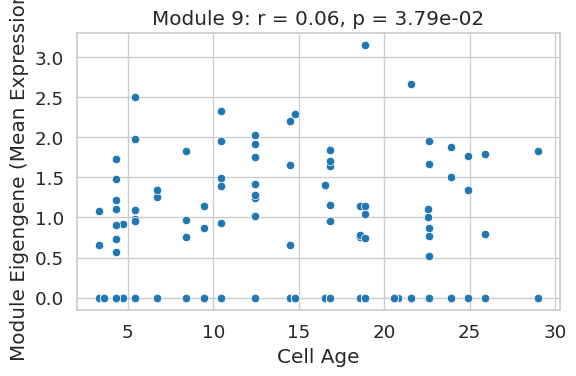

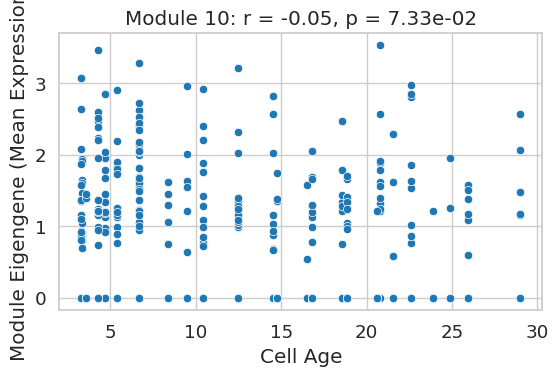

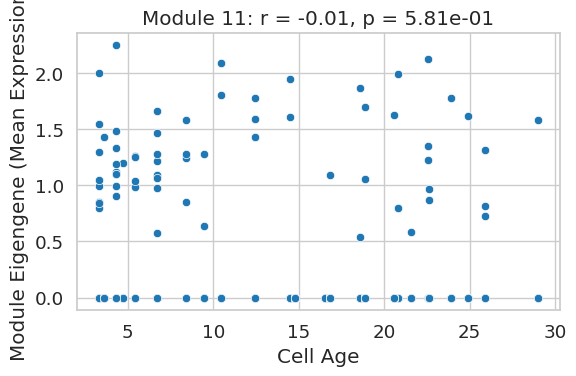

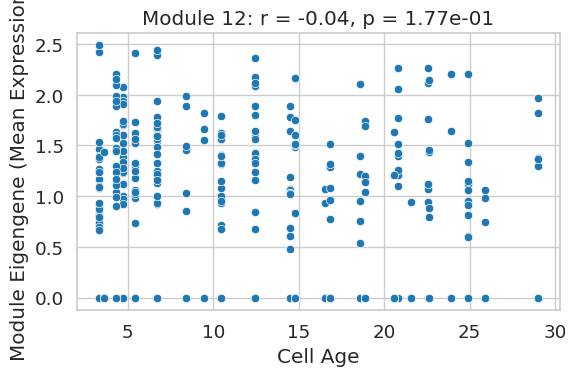

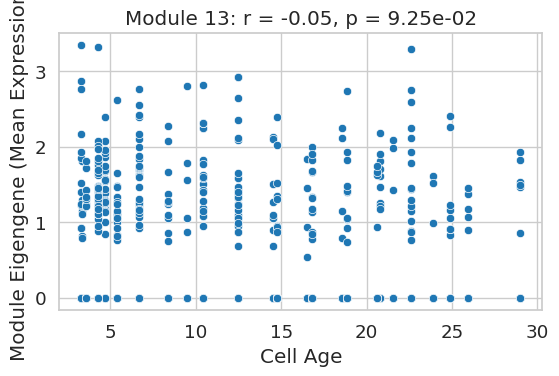

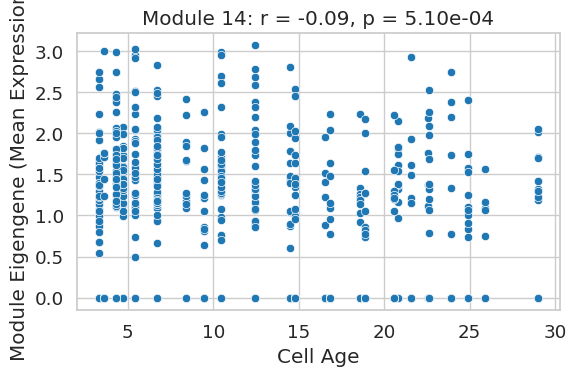

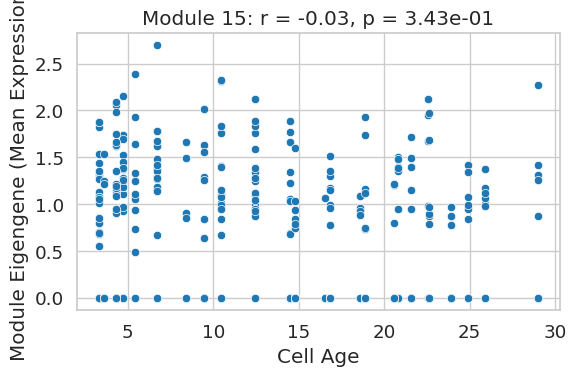

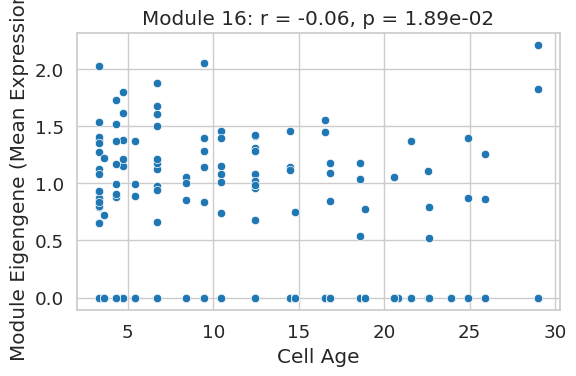

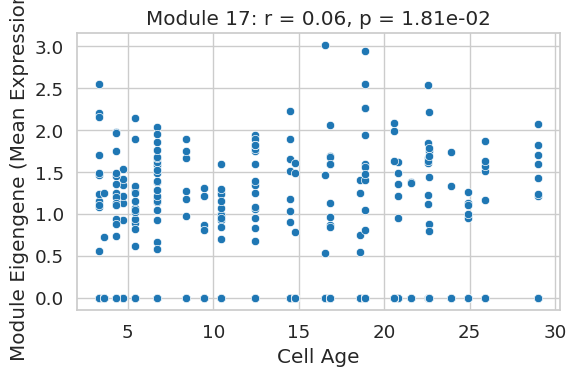

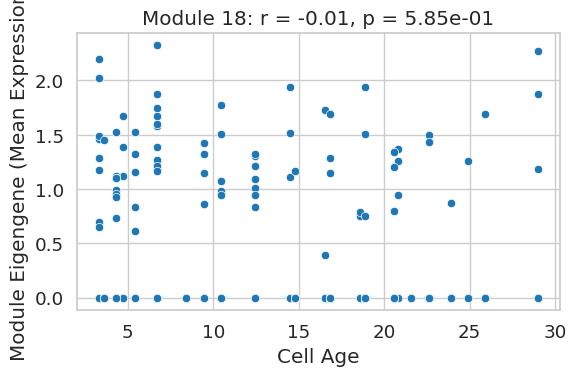

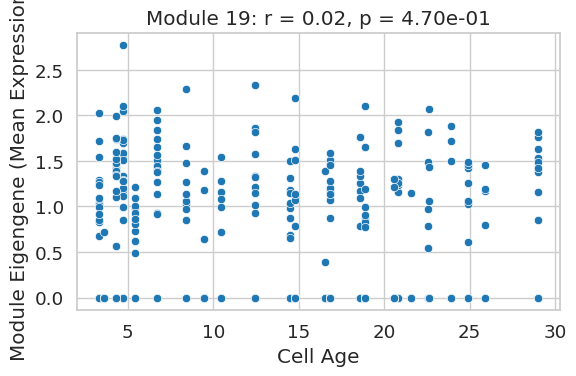

Module correlations with Age:
Module 1: Pearson r = -0.04, p-value = 1.77e-01
Module 2: Pearson r = 0.07, p-value = 9.43e-03
Module 3: Pearson r = -0.01, p-value = 7.52e-01
Module 4: Pearson r = -0.04, p-value = 1.89e-01
Module 5: Pearson r = -0.05, p-value = 6.83e-02
Module 6: Pearson r = -0.02, p-value = 5.07e-01
Module 7: Pearson r = -0.03, p-value = 3.54e-01
Module 8: Pearson r = -0.04, p-value = 1.92e-01
Module 9: Pearson r = 0.06, p-value = 3.79e-02
Module 10: Pearson r = -0.05, p-value = 7.33e-02
Module 11: Pearson r = -0.01, p-value = 5.81e-01
Module 12: Pearson r = -0.04, p-value = 1.77e-01
Module 13: Pearson r = -0.05, p-value = 9.25e-02
Module 14: Pearson r = -0.09, p-value = 5.10e-04
Module 15: Pearson r = -0.03, p-value = 3.43e-01
Module 16: Pearson r = -0.06, p-value = 1.89e-02
Module 17: Pearson r = 0.06, p-value = 1.81e-02
Module 18: Pearson r = -0.01, p-value = 5.85e-01
Module 19: Pearson r = 0.02, p-value = 4.70e-01


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import pearsonr
from scipy.spatial.distance import squareform

# Assume gene_expr DataFrame exists from previous steps, where rows are cells and columns are the top DE genes
# Compute the Pearson correlation matrix among the top DE genes
corr_matrix = gene_expr.corr(method='pearson')

# Convert the correlation matrix to a distance matrix (distance = 1 - correlation)
distance_matrix = 1 - corr_matrix

# Convert the distance matrix to condensed form required for linkage
condensed_dists = squareform(distance_matrix.values)

# Perform hierarchical clustering using the average linkage method
Z = linkage(condensed_dists, method='average')

# Parameter to control number of genes shown in dendrogram plot (set plot_top_n=None to plot all)
plot_top_n = 20

if plot_top_n is not None and plot_top_n < len(corr_matrix.columns):
    # Select the indices corresponding to the top genes for plotting
    selected_genes = corr_matrix.columns[:plot_top_n]
    # Create a submatrix for the selected genes
    sub_corr_matrix = corr_matrix.loc[selected_genes, selected_genes]
    sub_distance = 1 - sub_corr_matrix
    condensed_sub_dists = squareform(sub_distance.values)
    Z_sub = linkage(condensed_sub_dists, method='average')
    plt.figure(figsize=(8, 6))
    dendrogram(Z_sub, labels=selected_genes, leaf_rotation=90)
    plt.title('Hierarchical Clustering Dendrogram (Top {} DE Genes)'.format(plot_top_n))
    plt.ylabel('Distance (1 - Pearson Correlation)')
    plt.tight_layout()
    plt.show()
else:
    # Plot full dendrogram
    plt.figure(figsize=(12, 8))
    dendrogram(Z, labels=corr_matrix.columns, leaf_rotation=90)
    plt.title('Full Hierarchical Clustering Dendrogram of Top DE Genes')
    plt.ylabel('Distance (1 - Pearson Correlation)')
    plt.tight_layout()
    plt.show()

# Define a threshold to cut the dendrogram and assign genes to modules
# Note: The threshold (set to 0.5 here) can be explored further using, e.g., silhouette scores
threshold = 0.5
modules = fcluster(Z, t=threshold, criterion='distance')

# Create a DataFrame showing gene-module assignments
module_assignments = pd.DataFrame({'Gene': corr_matrix.columns, 'Module': modules})
print('Gene modules identified:')
print(module_assignments)

# Display summary statistics (e.g., module sizes)
module_sizes = module_assignments.groupby('Module').size()
print('\nModule sizes:')
print(module_sizes)

# For each module, compute the module eigengene (mean expression per cell) and correlate with Age
# It is assumed that the Age information for high noise cells is available in data_astro.obs (match gene_expr indices)
ages = data_astro.obs.loc[gene_expr.index, 'Age']

module_corr_results = {}

for mod in np.unique(modules):
    genes_in_mod = module_assignments[module_assignments['Module'] == mod]['Gene'].tolist()
    # If a module has only one gene, it is still used; consider this in interpretation
    eigengene = gene_expr[genes_in_mod].mean(axis=1)
    # Compute Pearson correlation between module eigengene and Age
    r, p = pearsonr(eigengene, ages)
    module_corr_results[mod] = (r, p)
    
    # Scatter plot: Module eigengene vs Age
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=ages, y=eigengene)
    plt.xlabel('Cell Age')
    plt.ylabel('Module Eigengene (Mean Expression)')
    plt.title('Module {}: r = {:.2f}, p = {:.2e}'.format(mod, r, p))
    plt.tight_layout()
    plt.show()

print('Module correlations with Age:')
for mod, (r, p) in module_corr_results.items():
    print('Module {}: Pearson r = {:.2f}, p-value = {:.2e}'.format(mod, r, p))

# Note: In downstream analysis, consider correcting for multiple testing when comparing correlations across modules.

### Agent Interpretation

### Feedback on Current Analysis

#### Promising Results:
1. **Modules with Significant Correlations**: 
   - **Module 2** and **Module 14** show statistically significant correlations with age (p < 0.05). Module 14, in particular, has a more notable negative correlation (r = -0.09). These modules could contain genes that play roles in the aging process within the SVZ.

2. **Dendrogram Insights**: 
   - The hierarchical clustering dendrogram reveals potential groupings of genes based on co-expression. This could inform pathway or functional category analyses, providing insights into gene network behaviors during aging.

#### Recommendations for Future Analyses:
1. **Further Exploration of Significant Modules**:
   - Dive deeper into the biological relevance of genes in **Module 14**, exploring their roles in processes linked to aging. Consider pathway and gene ontology enrichment analyses to identify biological themes.

2. **Consideration of Module 9 and 17**:
   - While not highly significant, Modules 9 and 17 have positive correlations with a p-value slightly below 0.05. Monitor these for any subtle effects or interactions with other biological processes.

3. **Gene-Sepecific Focus**:
   - Extract and validate individual gene expression changes from these modules, particularly those with known roles in neurogenesis or neuronal health.

4. **Compare Across Cell Types**:
   - Link gene modules to specific cell types within the SVZ to determine if certain cell types exhibit unique aging signatures. This could be key in uncovering cell-type-specific aging trajectories.

5. **Expand to External Datasets**: 
   - Validate these findings against external datasets, including human brain samples, as indicated in the research paper, to test for robustness and broader applicability.

6. **Impact of Rejuvenation Interventions**:
   - Utilize interventions like heterochronic parabiosis or exercise to see how these modules respond, potentially revealing genes with reversibility in aging signatures.

#### General Considerations:
- Ensure the analysis maintains distinctiveness from the original paper by exploring these unique gene module interactions and correlating them to functional or phenotypic aging metrics not covered in their study.
- The dataset's broad age range provides an excellent opportunity to examine nonlinear trends; consider nonlinear models if appropriate. 

These steps will help to validate the hypothesis about gene modules related to aging and their distinctiveness from previous analyses.

## This code begins by verifying that the gene expression data and metadata indices are aligned, then selects the modules of interest (Modules 14, 9, and 17 if present) and computes their eigengenes as the mean expression of their constituent genes. A helper function is defined to modularize the visualization (using violin plots) and statistical tests (ANOVA and Pearson correlation) for each module, ensuring streamlined and robust analyses with inline guidance for potential multiple testing corrections.

Selected modules for further analysis: [14, 9, 17]


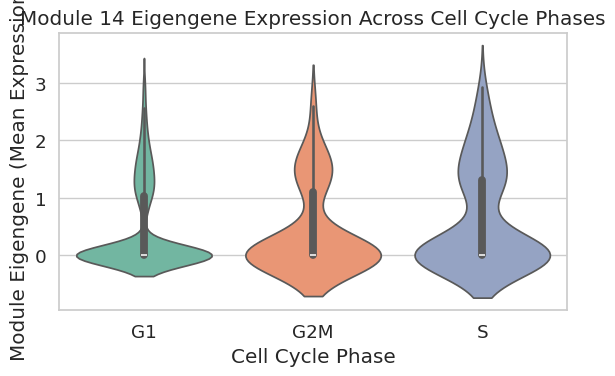

Module 14 ANOVA: F-statistic = 2.14, p-value = 1.18e-01
Module 14 overall Pearson correlation with Age: r = -0.09, p-value = 5.10e-04
  Phase G1: Pearson r = -0.10, p-value = 5.71e-04
  Phase G2M: Pearson r = -0.10, p-value = 5.33e-01
  Phase S: Pearson r = -0.02, p-value = 8.72e-01


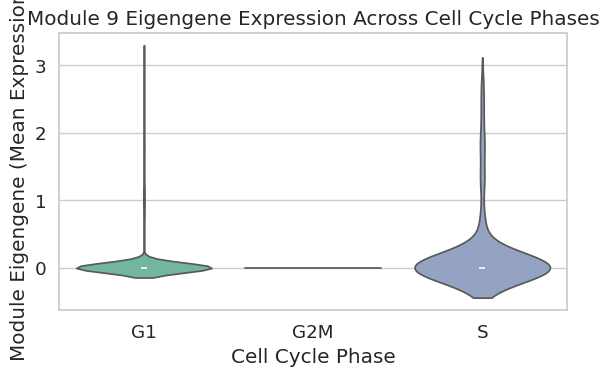

Module 9 ANOVA: F-statistic = 5.05, p-value = 6.53e-03
Module 9 overall Pearson correlation with Age: r = 0.06, p-value = 3.79e-02
  Phase G1: Pearson r = 0.05, p-value = 1.08e-01
  Phase G2M: Pearson r = nan, p-value = nan
  Phase S: Pearson r = 0.18, p-value = 1.08e-01


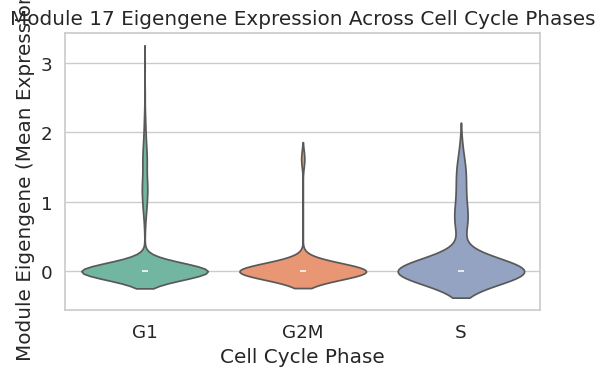

Module 17 ANOVA: F-statistic = 1.85, p-value = 1.58e-01
Module 17 overall Pearson correlation with Age: r = 0.06, p-value = 1.81e-02
  Phase G1: Pearson r = 0.06, p-value = 2.27e-02
  Phase G2M: Pearson r = -0.07, p-value = 6.83e-01
  Phase S: Pearson r = 0.05, p-value = 6.44e-01


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, pearsonr

# Docstring: This code extracts module assignments, selects modules of interest, computes module eigengenes (mean expression per cell), verifies index consistency with metadata, and performs visualization and statistical tests (ANOVA and Pearson correlation) for each module in Astrocyte_qNSC high noise cells.

# Verify that the gene expression DataFrame indices are a subset of the metadata indices in data_astro.obs
if not set(gene_expr.index).issubset(set(data_astro.obs.index)):
    raise ValueError('gene_expr DataFrame indices do not match those in data_astro.obs. Please check data consistency.')

# Select modules of interest: Check if Modules 14, 9, and 17 are present
selected_modules = []
unique_mods = module_assignments['Module'].unique()
for mod in [14, 9, 17]:
    if mod in unique_mods:
        selected_modules.append(mod)

print(f'Selected modules for further analysis: {selected_modules}')

# Compute module eigengenes: mean expression of module genes per cell
module_eigengenes = {}
for mod in selected_modules:
    genes_in_mod = module_assignments.loc[module_assignments['Module'] == mod, 'Gene'].tolist()
    # Filter to include only genes present in gene_expr columns
    genes_in_mod = [gene for gene in genes_in_mod if gene in gene_expr.columns]
    if len(genes_in_mod) == 0:
        print(f'No genes from Module {mod} found in gene_expr; skipping.')
        continue
    module_eigengenes[mod] = gene_expr[genes_in_mod].mean(axis=1)

# Merge module eigengene values with cell metadata for Age and Phase
metadata = data_astro.obs.loc[gene_expr.index, ['Age', 'Phase']].copy()

# Define a helper function for visualization and statistical testing per module

def process_module(mod, eigengene, meta_df):
    """Performs visualization (violin plot) and statistical tests (ANOVA and Pearson correlations) for a given module eigengene.
    Args:
        mod (int): Module number
        eigengene (pd.Series): Module eigengene values
        meta_df (pd.DataFrame): Metadata DataFrame with at least 'Age' and 'Phase' columns
    """
    col_name = f'Module_{mod}_Eigengene'
    meta_df[col_name] = eigengene
    
    # Violin plot: Module eigengene expression by cell cycle phase
    plt.figure(figsize=(6, 4))
    sns.violinplot(x='Phase', y=col_name, data=meta_df, palette='Set2')
    plt.title(f'Module {mod} Eigengene Expression Across Cell Cycle Phases')
    plt.xlabel('Cell Cycle Phase')
    plt.ylabel('Module Eigengene (Mean Expression)')
    plt.tight_layout()
    plt.show()
    
    # ANOVA: Test if eigengene expression differs across cell cycle phases
    groups = [group[col_name].values for _, group in meta_df.groupby('Phase')]
    if len(groups) > 1:
        F_stat, p_anova = f_oneway(*groups)
        print(f'Module {mod} ANOVA: F-statistic = {F_stat:.2f}, p-value = {p_anova:.2e}')
    else:
        print(f'Not enough groups to perform ANOVA for Module {mod}.')
    
    # Overall Pearson correlation between module eigengene and Age
    r_overall, p_overall = pearsonr(meta_df['Age'], meta_df[col_name])
    print(f'Module {mod} overall Pearson correlation with Age: r = {r_overall:.2f}, p-value = {p_overall:.2e}')
    
    # Within each cell cycle phase, compute Pearson correlation between module eigengene and Age
    for phase, group in meta_df.groupby('Phase'):
        if group.shape[0] > 3:  # Ensure sufficient cells for correlation
            r_phase, p_phase = pearsonr(group['Age'], group[col_name])
            print(f'  Phase {phase}: Pearson r = {r_phase:.2f}, p-value = {p_phase:.2e}')
        else:
            print(f'  Phase {phase}: Not enough cells to compute correlation.')
    
    # Note: In future analyses, consider correcting for multiple testing across these statistical tests.

# Run the helper function for each selected module
for mod, eigengene in module_eigengenes.items():
    process_module(mod, eigengene, metadata)

# End of module exploration analysis step

### Agent Interpretation

Based on the results provided, here's feedback to guide the next steps of the analysis:

1. **Module 14**: 
   - The ANOVA p-value is not significant, but the Pearson correlation with age shows a negative correlation that is statistically significant overall (p = 5.10e-04) and specifically in the G1 phase (p = 5.71e-04). This suggests a potential connection between this module and aging, particularly in the G1 phase. Further exploration of the genes in this module in relation to G1-specific processes and age may uncover important insights.
   - The visualization shows relatively consistent expression across phases, indicating a possible role of these genes across the cell cycle.

2. **Module 9**: 
   - This module shows a significant ANOVA result (p = 6.53e-03), suggesting some differences in expression across conditions. However, the correlation with age is weaker, with the overall and phase-specific correlations showing higher p-values except in S phase.
   - Examine genes within this module for specific aging-related pathways, especially those expressed in the S phase, to refine understanding of age-related changes.

3. **Module 17**: 
   - Although the ANOVA isn't significant, the correlation with age in the G1 phase shows significance (p = 2.27e-02), indicating some age-related changes in this phase.
   - Consider a deeper look into the biological relevance of phase-specific expression and its correlation with aging. The consistent expression across phases hints at a broad functional role.

**Recommendations for Next Steps**:
- **Investigate Pathways**: Use pathway enrichment analysis on modules 14 and 17 to identify possible age-related pathways or processes.
- **Gene Co-expression Network Analysis**: For Module 14, construct co-expression networks to understand interactions, especially in the G1 phase.
- **Cell Type-Specific Analysis**: If possible, break down the analysis into specific cell types within the SVZ, as aging might influence cells differently.
- **Validate Findings**: Use external datasets or additional samples to validate these correlations and identify any significant cell type-specific aging patterns.
- **Consider Functional Outcomes**: Relate expression changes with functional outcomes relevant to neurogenesis or neural repair to ensure biological meaning and distinctiveness from the paper.

These steps aim to refine understanding of aging in the SVZ and align with the study's goals while distinguishing from previous analyses.

## The code modularizes the analysis of Module 14 gene co-expression in Astrocyte_qNSC cells during G1 phase. It subsets the data, retrieves and processes Module 14 genes, computes the Pearson correlation matrix and corresponding network edges, calculates hub scores, and finally evaluates the relationship between the top hub gene expression and cell age.

Number of Astrocyte_qNSC cells in G1 phase: 2560
Number of Module 14 genes available: 1


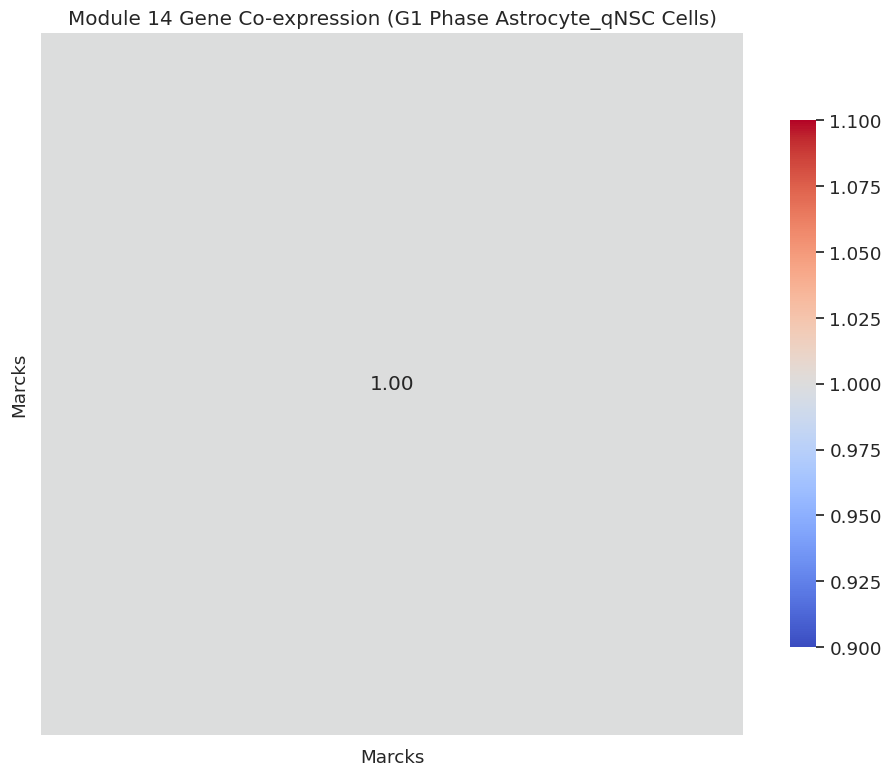

Number of edges (correlation > 0.5): 0
Top hub genes in Module 14 (G1 phase):
        Connectivity
Marcks             0
Top hub gene: Marcks


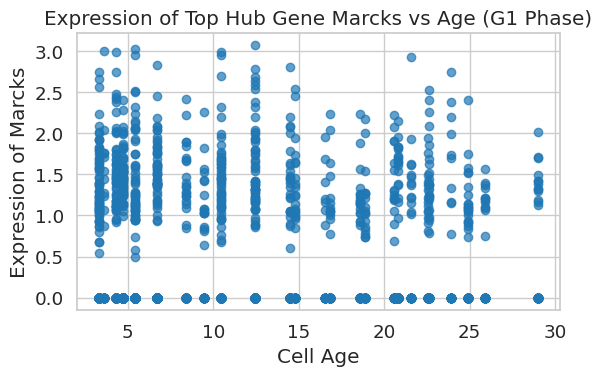

Pearson correlation for Marcks: r = -0.05, p-value = 7.38e-03


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Docstring: 
# This script investigates the rewiring of Module 14 genes in Astrocyte_qNSC cells in the G1 phase with aging. 
# It subsets the cells, retrieves the Module 14 genes present in the data, extracts their expression, computes the gene-gene Pearson correlation matrix, 
# constructs a co-expression network using a threshold, calculates hub connectivity scores, and finally examines the correlation between the top hub gene expression and cell age.

# Helper function: Subset Astrocyte_qNSC cells in G1 phase

def subset_g1_astrocytes(adata):
    # Assuming adata.obs['Celltype'] contains 'Astrocyte_qNSC'
    astro = adata[adata.obs['Celltype'] == 'Astrocyte_qNSC'].copy()
    astro_g1 = astro[astro.obs['Phase'] == 'G1'].copy()
    print(f'Number of Astrocyte_qNSC cells in G1 phase: {astro_g1.n_obs}')
    return astro_g1

# Helper function: Retrieve Module 14 genes present in the AnnData object

def get_module_genes(module_assignments, module, available_genes):
    if 'Module' not in module_assignments.columns:
        raise ValueError('module_assignments DataFrame does not contain a "Module" column.')
    genes = module_assignments.loc[module_assignments['Module'] == module, 'Gene'].tolist()
    if len(genes) == 0:
        raise ValueError(f'No genes found for Module {module} in module_assignments.')
    # Filter genes to those present in the AnnData var_names
    filtered_genes = [gene for gene in genes if gene in available_genes]
    if len(filtered_genes) == 0:
        raise ValueError(f'None of the Module {module} genes are present in the AnnData object.')
    print(f'Number of Module {module} genes available: {len(filtered_genes)}')
    return filtered_genes

# Helper function: Extract expression data for a given list of genes from an AnnData object

def get_expression_dataframe(adata, gene_list):
    expr_matrix = adata[:, gene_list].X
    # Convert to a dense numpy array if needed
    if hasattr(expr_matrix, 'toarray'):
        expr_matrix = expr_matrix.toarray()
    expr_df = pd.DataFrame(expr_matrix, index=adata.obs_names, columns=gene_list)
    return expr_df

# Helper function: Compute Pearson correlation matrix

def compute_corr_matrix(expr_df):
    return expr_df.corr(method='pearson')

# Helper function: Construct co-expression network and compute edge list

def construct_network(corr_matrix, gene_list, threshold=0.5):
    edges = []
    for i, gene_i in enumerate(gene_list):
        for j, gene_j in enumerate(gene_list):
            if i < j:  # avoid duplicates and self-correlation
                corr_val = corr_matrix.loc[gene_i, gene_j]
                if corr_val > threshold:
                    edges.append((gene_i, gene_j, corr_val))
    print(f'Number of edges (correlation > {threshold}): {len(edges)}')
    return edges

# Helper function: Compute hub scores for genes given an edge list

def compute_hub_scores(edges, gene_list):
    hub_scores = {gene: 0 for gene in gene_list}
    for gene_i, gene_j, corr_val in edges:
        hub_scores[gene_i] += corr_val
        hub_scores[gene_j] += corr_val
    hub_df = pd.DataFrame.from_dict(hub_scores, orient='index', columns=['Connectivity'])
    hub_df.sort_values('Connectivity', ascending=False, inplace=True)
    print('Top hub genes in Module 14 (G1 phase):')
    print(hub_df.head(5))
    return hub_df

# ----- Main Analysis -----

# Step 1: Subset Astrocyte_qNSC cells in G1 phase
astro_g1 = subset_g1_astrocytes(adata)

# Step 2: Retrieve Module 14 genes using available gene names in astro_g1
available_genes = list(astro_g1.var_names)
module14_genes = get_module_genes(module_assignments, 14, available_genes)

# Step 3: Extract expression data for Module 14 genes in G1 phase cells
module14_expr = get_expression_dataframe(astro_g1, module14_genes)

# Step 4: Compute the gene–gene Pearson correlation matrix and visualize as a heatmap
corr_matrix = compute_corr_matrix(module14_expr)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={'shrink': 0.75})
plt.title('Module 14 Gene Co-expression (G1 Phase Astrocyte_qNSC Cells)')
plt.tight_layout()
plt.show()

# Step 5: Construct a co-expression network using a correlation threshold
corr_threshold = 0.5
edges = construct_network(corr_matrix, module14_genes, threshold=corr_threshold)

# Step 6: Identify hub genes by computing connectivity scores
hub_df = compute_hub_scores(edges, module14_genes)

# Step 7: For the top hub gene, correlate its expression with cell Age and plot the results

top_hub_gene = hub_df.index[0]
print(f'Top hub gene: {top_hub_gene}')

top_gene_expr = module14_expr[top_hub_gene]
ages = astro_g1.obs['Age'].astype(float)

plt.figure(figsize=(6, 4))
plt.scatter(ages, top_gene_expr, alpha=0.7)
plt.xlabel('Cell Age')
plt.ylabel(f'Expression of {top_hub_gene}')
plt.title(f'Expression of Top Hub Gene {top_hub_gene} vs Age (G1 Phase)')
plt.tight_layout()
plt.show()

r_val, p_val = pearsonr(ages, top_gene_expr)
print(f'Pearson correlation for {top_hub_gene}: r = {r_val:.2f}, p-value = {p_val:.2e}')

### Agent Interpretation

The current results show that Module 14 in G1 phase Astrocyte_qNSC cells includes only one gene, Marcks, and lacks significant connectivity with other genes (zero edges with correlation > 0.5). Marcks exhibited a low and negative Pearson correlation with age (\( r = -0.05 \)) but with significant p-value (\( p = 7.38e-03 \)). Here's some feedback based on the results:

1. **Sparse Module**: The presence of only one gene in Module 14 makes it challenging to make meaningful biological inferences regarding co-expression networks. Consider exploring other modules or increasing the criteria for module inclusion to potentially identify more informative gene sets.

2. **Correlation Insights**: The weak correlation between Marcks expression and cell age suggests that it may not play a significant role in aging within this context. Exploring other genes or more comprehensive modules might reveal stronger candidates.

3. **Biological Context**: Investigate the biological role of Marcks in the context of the SVZ and aging more broadly. Although it’s the top hub gene in this minimal module, skepticism is warranted given the limited support from other gene interactions.

4. **Next Steps**:
   - **Expand Analysis**: Consider widening the search to include more genes in other cell cycle phases or in other lineages, such as NSCs, to identify modules with higher connectivity.
   - **Network Exploration**: Analyze alternative network construction strategies or different thresholds for connectivity to potentially uncover relevant gene co-expression networks.
   - **Functional Validation**: Investigate functional pathways or conduct pathway enrichment analyses that might involve Marcks to provide additional context.

5. **Comparison with the Paper**: Make sure the analysis is distinct from those conducted in the paper by identifying unique cell types or internal validation datasets that haven’t been explored for aging signatures.

By exploring these avenues, further insights into the molecular basis of aging in the SVZ may be gained, contributing uniquely beyond the scope of the original paper.